<a href="https://colab.research.google.com/github/DuaeZahra/Hybrid-Parallel-Database-Query-Engine/blob/main/cs317_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##using pthreads and cuda

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Sun May  4 09:47:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8       

In [ ]:
# Install any additional packages if needed
!pip install numpy pandas matplotlib

import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
from google.colab import files

# Create a directory for our C++ and CUDA source files
!mkdir -p db_engine

# Create the Pthread Implementation (CPU)

In [ ]:
%%writefile db_engine/pthread_query.cpp
#include <pthread.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>
#include <time.h>

#define MAX_THREADS 16
#define MAX_DATA_SIZE 10000000

// Shared data structure
typedef struct {
    int* data;
    int start;
    int end;
    int filter_value;
    int* results;
    int* result_count;
    pthread_mutex_t* mutex;
} thread_data_t;

// Simple filter operation (similar to WHERE clause in SQL)
void* filter_operation(void* arg) {
    thread_data_t* thread_data = (thread_data_t*)arg;
    int local_count = 0;
    int* local_results = (int*)malloc(sizeof(int) * (thread_data->end - thread_data->start));

    // Process the assigned chunk of data
    for (int i = thread_data->start; i < thread_data->end; i++) {
        if (thread_data->data[i] > thread_data->filter_value) {
            local_results[local_count++] = thread_data->data[i];
        }
    }

    // Critical section - update shared results
    pthread_mutex_lock(thread_data->mutex);
    memcpy(thread_data->results + *thread_data->result_count,
           local_results,
           local_count * sizeof(int));
    *thread_data->result_count += local_count;
    pthread_mutex_unlock(thread_data->mutex);

    free(local_results);
    return NULL;
}

// Main function that executes parallel query using pthreads
extern "C" int execute_pthread_query(int* data, int data_size, int filter_value,
                                    int* results, int num_threads) {
    pthread_t threads[MAX_THREADS];
    thread_data_t thread_data[MAX_THREADS];
    pthread_mutex_t mutex;
    int result_count = 0;

    // Initialize mutex
    pthread_mutex_init(&mutex, NULL);

    // Calculate chunk size for each thread
    int chunk_size = data_size / num_threads;

    // Create threads
    for (int i = 0; i < num_threads; i++) {
        thread_data[i].data = data;
        thread_data[i].start = i * chunk_size;
        thread_data[i].end = (i == num_threads - 1) ? data_size : (i + 1) * chunk_size;
        thread_data[i].filter_value = filter_value;
        thread_data[i].results = results;
        thread_data[i].result_count = &result_count;
        thread_data[i].mutex = &mutex;

        pthread_create(&threads[i], NULL, filter_operation, &thread_data[i]);
    }

    // Join threads
    for (int i = 0; i < num_threads; i++) {
        pthread_join(threads[i], NULL);
    }

    // Clean up
    pthread_mutex_destroy(&mutex);

    return result_count;
}

Writing db_engine/pthread_query.cpp


# Create the CUDA Implementation (GPU)

In [ ]:
%%writefile db_engine/cuda_query.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

// CUDA kernel for filtering data (similar to WHERE clause)
__global__ void filter_kernel(int* data, int data_size, int filter_value,
                              int* results, int* result_count) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < data_size) {
        if (data[idx] > filter_value) {
            // Atomic operation to get the next available position in results array
            int position = atomicAdd(result_count, 1);
            results[position] = data[idx];
        }
    }
}

// Main function that executes query on GPU
extern "C" int execute_cuda_query(int* h_data, int data_size, int filter_value,
                                 int* h_results) {
    int *d_data, *d_results, *d_result_count;
    int h_result_count = 0;

    // Allocate memory on GPU
    cudaMalloc((void**)&d_data, sizeof(int) * data_size);
    cudaMalloc((void**)&d_results, sizeof(int) * data_size); // Worst case: all elements pass filter
    cudaMalloc((void**)&d_result_count, sizeof(int));

    // Copy data to GPU
    cudaMemcpy(d_data, h_data, sizeof(int) * data_size, cudaMemcpyHostToDevice);
    cudaMemset(d_result_count, 0, sizeof(int));

    // Configure kernel execution
    int block_size = 256;
    int grid_size = (data_size + block_size - 1) / block_size;

    // Execute kernel
    filter_kernel<<<grid_size, block_size>>>(d_data, data_size, filter_value,
                                           d_results, d_result_count);

    // Copy result count back to host
    cudaMemcpy(&h_result_count, d_result_count, sizeof(int), cudaMemcpyDeviceToHost);

    // Copy results back to host if any
    if (h_result_count > 0) {
        cudaMemcpy(h_results, d_results, sizeof(int) * h_result_count, cudaMemcpyDeviceToHost);
    }

    // Free GPU memory
    cudaFree(d_data);
    cudaFree(d_results);
    cudaFree(d_result_count);

    return h_result_count;
}

Overwriting db_engine/cuda_query.cu


# Create the Hybrid Implementation (CPU + GPU)

In [ ]:
%%writefile db_engine/hybrid_query.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda_runtime.h>
#include <pthread.h>

#define MAX_THREADS 16

// Thread data structure for CPU work
typedef struct {
    int* data;
    int start;
    int end;
    int filter_value;
    int* results;
    int* result_count;
    pthread_mutex_t* mutex;
} thread_data_t;

// CPU worker function for Pthreads
void* filter_operation_cpu(void* arg) {
    thread_data_t* thread_data = (thread_data_t*)arg;
    int local_count = 0;
    int* local_results = (int*)malloc(sizeof(int) * (thread_data->end - thread_data->start));

    // Process the assigned chunk of data
    for (int i = thread_data->start; i < thread_data->end; i++) {
        if (thread_data->data[i] > thread_data->filter_value) {
            local_results[local_count++] = thread_data->data[i];
        }
    }

    // Critical section - update shared results
    pthread_mutex_lock(thread_data->mutex);
    memcpy(thread_data->results + *thread_data->result_count,
           local_results,
           local_count * sizeof(int));
    *thread_data->result_count += local_count;
    pthread_mutex_unlock(thread_data->mutex);

    free(local_results);
    return NULL;
}

// CUDA kernel for filtering data
__global__ void filter_kernel_gpu(int* data, int data_size, int filter_value,
                              int* results, int* result_count) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < data_size) {
        if (data[idx] > filter_value) {
            // Atomic operation to get the next available position in results array
            int position = atomicAdd(result_count, 1);
            results[position] = data[idx];
        }
    }
}

// Main function that executes hybrid query
extern "C" int execute_hybrid_query(int* data, int data_size, int filter_value,
                                   int* results, int cpu_threads, float gpu_ratio) {

    // Determine amount of work for GPU and CPU
    int gpu_size = (int)(data_size * gpu_ratio);
    int cpu_size = data_size - gpu_size;

    int cpu_result_count = 0;
    int gpu_result_count = 0;
    int* gpu_results = (int*)malloc(sizeof(int) * gpu_size); // For GPU results

    // ===== GPU PORTION =====
    int *d_data, *d_results, *d_result_count;

    // Allocate memory on GPU
    cudaMalloc((void**)&d_data, sizeof(int) * gpu_size);
    cudaMalloc((void**)&d_results, sizeof(int) * gpu_size); // Worst case: all elements pass filter
    cudaMalloc((void**)&d_result_count, sizeof(int));

    // Copy data to GPU
    cudaMemcpy(d_data, data, sizeof(int) * gpu_size, cudaMemcpyHostToDevice);
    cudaMemset(d_result_count, 0, sizeof(int));

    // Configure kernel execution
    int block_size = 256;
    int grid_size = (gpu_size + block_size - 1) / block_size;

    // ===== CPU PORTION =====
    pthread_t threads[MAX_THREADS];
    thread_data_t thread_data[MAX_THREADS];
    pthread_mutex_t mutex;

    // Initialize mutex
    pthread_mutex_init(&mutex, NULL);

    // Calculate chunk size for each CPU thread
    int chunk_size = cpu_size / cpu_threads;

    // Create CPU threads
    for (int i = 0; i < cpu_threads; i++) {
        thread_data[i].data = data + gpu_size; // Start after GPU portion
        thread_data[i].start = i * chunk_size;
        thread_data[i].end = (i == cpu_threads - 1) ? cpu_size : (i + 1) * chunk_size;
        thread_data[i].filter_value = filter_value;
        thread_data[i].results = results; // CPU results go directly to final results array
        thread_data[i].result_count = &cpu_result_count;
        thread_data[i].mutex = &mutex;

        pthread_create(&threads[i], NULL, filter_operation_cpu, &thread_data[i]);
    }

    // Execute GPU kernel in parallel with CPU threads
    filter_kernel_gpu<<<grid_size, block_size>>>(d_data, gpu_size, filter_value,
                                             d_results, d_result_count);

    // Join CPU threads
    for (int i = 0; i < cpu_threads; i++) {
        pthread_join(threads[i], NULL);
    }

    // Copy GPU result count back to host
    cudaMemcpy(&gpu_result_count, d_result_count, sizeof(int), cudaMemcpyDeviceToHost);

    // Copy GPU results back to host if any
    if (gpu_result_count > 0) {
        cudaMemcpy(gpu_results, d_results, sizeof(int) * gpu_result_count, cudaMemcpyDeviceToHost);

        // Copy GPU results to the final results array (after CPU results)
        memcpy(results + cpu_result_count, gpu_results, sizeof(int) * gpu_result_count);
    }

    // Free GPU memory
    cudaFree(d_data);
    cudaFree(d_results);
    cudaFree(d_result_count);
    free(gpu_results);

    // Destroy mutex
    pthread_mutex_destroy(&mutex);

    // Return total number of results
    return cpu_result_count + gpu_result_count;
}

Writing db_engine/hybrid_query.cu


# Compile the Code

In [ ]:
# Compile our code with nvcc - added -fPIC flag
!cd db_engine && nvcc -c cuda_query.cu -o cuda_query.o -Xcompiler -fPIC
!cd db_engine && nvcc -c hybrid_query.cu -o hybrid_query.o -Xcompiler -fPIC
!cd db_engine && g++ -c pthread_query.cpp -o pthread_query.o -fPIC -lpthread

# Create shared libraries
!cd db_engine && g++ -shared -o libpthread_query.so pthread_query.o -lpthread
!cd db_engine && nvcc -shared -o libcuda_query.so cuda_query.o
!cd db_engine && nvcc -shared -o libhybrid_query.so hybrid_query.o -lpthread

# Load the Libraries in Python

In [ ]:
# Load the libraries in Python
import ctypes
import numpy as np

# Load the shared libraries
pthread_lib = ctypes.CDLL('./db_engine/libpthread_query.so')
cuda_lib = ctypes.CDLL('./db_engine/libcuda_query.so')
hybrid_lib = ctypes.CDLL('./db_engine/libhybrid_query.so')

# Define argument and return types for the C functions
pthread_lib.execute_pthread_query.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_int,
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int
]
pthread_lib.execute_pthread_query.restype = ctypes.c_int

cuda_lib.execute_cuda_query.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_int,
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS')
]
cuda_lib.execute_cuda_query.restype = ctypes.c_int

hybrid_lib.execute_hybrid_query.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_int,
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_float
]
hybrid_lib.execute_hybrid_query.restype = ctypes.c_int

# Define Testing Functions

In [ ]:
# Generate some test data (simulating a database table)
def generate_test_data(size):
    return np.random.randint(0, 1000, size=size, dtype=np.int32)

# Test function for Pthread implementation
def test_pthread(data, filter_value, num_threads):
    results = np.zeros(len(data), dtype=np.int32)
    start_time = time.time()
    result_count = pthread_lib.execute_pthread_query(data, len(data), filter_value, results, num_threads)
    end_time = time.time()
    return results[:result_count], end_time - start_time

# Test function for CUDA implementation
def test_cuda(data, filter_value):
    results = np.zeros(len(data), dtype=np.int32)
    start_time = time.time()
    result_count = cuda_lib.execute_cuda_query(data, len(data), filter_value, results)
    end_time = time.time()
    return results[:result_count], end_time - start_time

# Test function for Hybrid implementation
def test_hybrid(data, filter_value, cpu_threads, gpu_ratio):
    results = np.zeros(len(data), dtype=np.int32)
    start_time = time.time()
    result_count = hybrid_lib.execute_hybrid_query(data, len(data), filter_value, results, cpu_threads, gpu_ratio)
    end_time = time.time()
    return results[:result_count], end_time - start_time

# Performance Testing

In [ ]:
# Run performance tests
data_sizes = [100000, 500000, 1000000, 5000000]
filter_value = 500  # Select elements > 500
num_threads = 4     # Number of CPU threads to use
gpu_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]  # Different GPU/CPU workload distributions

# Results storage
pthread_times = []
cuda_times = []
hybrid_times = []

# Run tests for different data sizes
for size in data_sizes:
    print(f"\nTesting with data size: {size}")

    # Generate test data
    data = generate_test_data(size)

    # Test Pthread implementation
    pthread_results, pthread_time = test_pthread(data, filter_value, num_threads)
    pthread_times.append(pthread_time)
    print(f"Pthread execution time: {pthread_time:.4f} seconds, Found {len(pthread_results)} matches")

    # Test CUDA implementation
    cuda_results, cuda_time = test_cuda(data, filter_value)
    cuda_times.append(cuda_time)
    print(f"CUDA execution time: {cuda_time:.4f} seconds, Found {len(cuda_results)} matches")

    # Test Hybrid implementation with different GPU/CPU ratios
    best_hybrid_time = float('inf')
    best_ratio = 0.0

    for ratio in gpu_ratios:
        hybrid_results, hybrid_time = test_hybrid(data, filter_value, num_threads, ratio)
        print(f"  Hybrid (GPU ratio {ratio:.2f}) execution time: {hybrid_time:.4f} seconds, Found {len(hybrid_results)} matches")

        if hybrid_time < best_hybrid_time:
            best_hybrid_time = hybrid_time
            best_ratio = ratio

    hybrid_times.append(best_hybrid_time)
    print(f"Best hybrid performance with GPU ratio {best_ratio:.2f}: {best_hybrid_time:.4f} seconds")


Testing with data size: 100000
Pthread execution time: 0.0021 seconds, Found 50046 matches
CUDA execution time: 0.3921 seconds, Found 0 matches
  Hybrid (GPU ratio 0.00) execution time: 0.0054 seconds, Found 50046 matches
  Hybrid (GPU ratio 0.25) execution time: 0.0009 seconds, Found 37494 matches
  Hybrid (GPU ratio 0.50) execution time: 0.0008 seconds, Found 25036 matches
  Hybrid (GPU ratio 0.75) execution time: 0.0006 seconds, Found 12444 matches
  Hybrid (GPU ratio 1.00) execution time: 0.0005 seconds, Found 0 matches
Best hybrid performance with GPU ratio 1.00: 0.0005 seconds

Testing with data size: 500000
Pthread execution time: 0.0031 seconds, Found 249122 matches
CUDA execution time: 0.0010 seconds, Found 0 matches
  Hybrid (GPU ratio 0.00) execution time: 0.0035 seconds, Found 249122 matches
  Hybrid (GPU ratio 0.25) execution time: 0.0029 seconds, Found 186692 matches
  Hybrid (GPU ratio 0.50) execution time: 0.0020 seconds, Found 124514 matches
  Hybrid (GPU ratio 0.75) 

# Performance Visualization

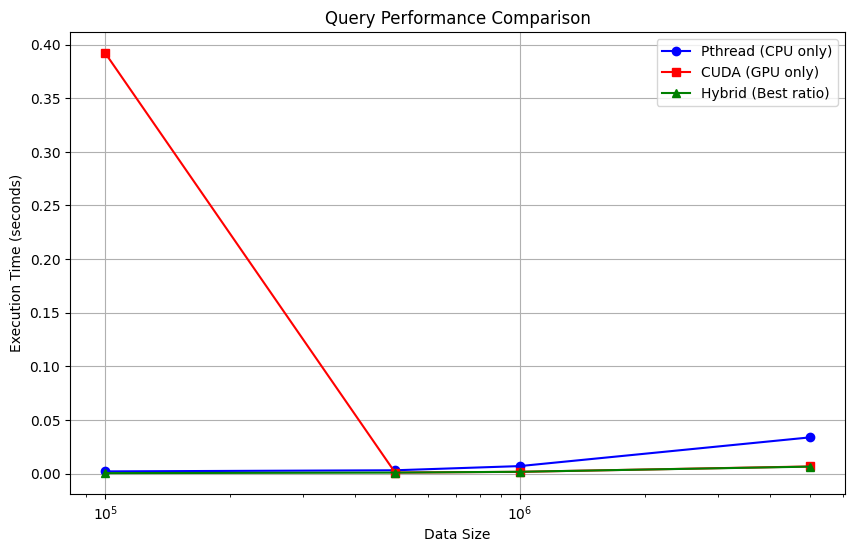

In [ ]:
# Plot performance comparison
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, pthread_times, 'b-o', label='Pthread (CPU only)')
plt.plot(data_sizes, cuda_times, 'r-s', label='CUDA (GPU only)')
plt.plot(data_sizes, hybrid_times, 'g-^', label='Hybrid (Best ratio)')
plt.xlabel('Data Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Query Performance Comparison')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

# Advanced Query - GroupBy Implementation

In [ ]:
%%writefile db_engine/advanced_query.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda_runtime.h>
#include <pthread.h>

#define MAX_THREADS 16
#define MAX_GROUPS 100

// Thread data structure for CPU groupby
typedef struct {
    int* values;
    int* keys;
    int start;
    int end;
    int* group_sums;
    int* group_counts;
    pthread_mutex_t* mutex;
} groupby_thread_data_t;

// CPU worker function for groupby
void* groupby_operation_cpu(void* arg) {
    groupby_thread_data_t* thread_data = (groupby_thread_data_t*)arg;

    // Local group counters
    int local_sums[MAX_GROUPS] = {0};
    int local_counts[MAX_GROUPS] = {0};

    // Process the assigned chunk of data
    for (int i = thread_data->start; i < thread_data->end; i++) {
        int key = thread_data->keys[i];
        if (key >= 0 && key < MAX_GROUPS) {
            local_sums[key] += thread_data->values[i];
            local_counts[key]++;
        }
    }

    // Critical section - update shared results
    pthread_mutex_lock(thread_data->mutex);
    for (int i = 0; i < MAX_GROUPS; i++) {
        thread_data->group_sums[i] += local_sums[i];
        thread_data->group_counts[i] += local_counts[i];
    }
    pthread_mutex_unlock(thread_data->mutex);

    return NULL;
}

// CUDA kernel for groupby operation
__global__ void groupby_kernel_gpu(int* values, int* keys, int data_size,
                                 int* group_sums, int* group_counts) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < data_size) {
        int key = keys[idx];
        if (key >= 0 && key < MAX_GROUPS) {
            atomicAdd(&group_sums[key], values[idx]);
            atomicAdd(&group_counts[key], 1);
        }
    }
}

// Main function that executes hybrid groupby query
extern "C" void execute_hybrid_groupby(int* values, int* keys, int data_size,
                                     int* group_sums, int* group_counts,
                                     int cpu_threads, float gpu_ratio) {

    // Determine amount of work for GPU and CPU
    int gpu_size = (int)(data_size * gpu_ratio);
    int cpu_size = data_size - gpu_size;

    // Initialize group sums and counts to zero
    memset(group_sums, 0, sizeof(int) * MAX_GROUPS);
    memset(group_counts, 0, sizeof(int) * MAX_GROUPS);

    // ===== GPU PORTION =====
    if (gpu_size > 0) {
        int *d_values, *d_keys, *d_group_sums, *d_group_counts;

        // Allocate memory on GPU
        cudaMalloc((void**)&d_values, sizeof(int) * gpu_size);
        cudaMalloc((void**)&d_keys, sizeof(int) * gpu_size);
        cudaMalloc((void**)&d_group_sums, sizeof(int) * MAX_GROUPS);
        cudaMalloc((void**)&d_group_counts, sizeof(int) * MAX_GROUPS);

        // Copy data to GPU
        cudaMemcpy(d_values, values, sizeof(int) * gpu_size, cudaMemcpyHostToDevice);
        cudaMemcpy(d_keys, keys, sizeof(int) * gpu_size, cudaMemcpyHostToDevice);
        cudaMemset(d_group_sums, 0, sizeof(int) * MAX_GROUPS);
        cudaMemset(d_group_counts, 0, sizeof(int) * MAX_GROUPS);

        // Configure kernel execution
        int block_size = 256;
        int grid_size = (gpu_size + block_size - 1) / block_size;

        // Execute GPU kernel
        groupby_kernel_gpu<<<grid_size, block_size>>>(d_values, d_keys, gpu_size,
                                                  d_group_sums, d_group_counts);

        // Copy results back to host
        int* gpu_group_sums = (int*)malloc(sizeof(int) * MAX_GROUPS);
        int* gpu_group_counts = (int*)malloc(sizeof(int) * MAX_GROUPS);

        cudaMemcpy(gpu_group_sums, d_group_sums, sizeof(int) * MAX_GROUPS, cudaMemcpyDeviceToHost);
        cudaMemcpy(gpu_group_counts, d_group_counts, sizeof(int) * MAX_GROUPS, cudaMemcpyDeviceToHost);

        // Add GPU results to final results
        for (int i = 0; i < MAX_GROUPS; i++) {
            group_sums[i] += gpu_group_sums[i];
            group_counts[i] += gpu_group_counts[i];
        }

        // Free GPU memory
        cudaFree(d_values);
        cudaFree(d_keys);
        cudaFree(d_group_sums);
        cudaFree(d_group_counts);
        free(gpu_group_sums);
        free(gpu_group_counts);
    }

    // ===== CPU PORTION =====
    if (cpu_size > 0) {
        pthread_t threads[MAX_THREADS];
        groupby_thread_data_t thread_data[MAX_THREADS];
        pthread_mutex_t mutex;

        // Initialize mutex
        pthread_mutex_init(&mutex, NULL);

        // Calculate chunk size for each CPU thread
        int chunk_size = cpu_size / cpu_threads;

        // Create CPU threads
        for (int i = 0; i < cpu_threads; i++) {
            thread_data[i].values = values + gpu_size; // Start after GPU portion
            thread_data[i].keys = keys + gpu_size;
            thread_data[i].start = i * chunk_size;
            thread_data[i].end = (i == cpu_threads - 1) ? cpu_size : (i + 1) * chunk_size;
            thread_data[i].group_sums = group_sums;
            thread_data[i].group_counts = group_counts;
            thread_data[i].mutex = &mutex;

            pthread_create(&threads[i], NULL, groupby_operation_cpu, &thread_data[i]);
        }

        // Join CPU threads
        for (int i = 0; i < cpu_threads; i++) {
            pthread_join(threads[i], NULL);
        }

        // Destroy mutex
        pthread_mutex_destroy(&mutex);
    }
}

Writing db_engine/advanced_query.cu


# Compile the Advanced Query Code

In [ ]:
# First, check if the directory exists, create it if needed
!mkdir -p db_engine

# Compile the advanced query code with -fPIC flag
!cd db_engine && nvcc -c advanced_query.cu -o advanced_query.o -Xcompiler -fPIC

# Create the shared library with -fPIC flag
!cd db_engine && nvcc -shared -o libadvanced_query.so advanced_query.o -lpthread -Xcompiler -fPIC

# Verify the library was created
!ls -l db_engine/

# Now load the library
import ctypes
import numpy as np

# Load the advanced query library
advanced_lib = ctypes.CDLL('./db_engine/libadvanced_query.so')

# Define argument types for the groupby function
advanced_lib.execute_hybrid_groupby.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_float
]
advanced_lib.execute_hybrid_groupby.restype = None

print("Library successfully loaded!")

total 3040
-rw-r--r-- 1 root root    5305 May  4 09:48 advanced_query.cu
-rw-r--r-- 1 root root   13144 May  4 09:48 advanced_query.o
-rw-r--r-- 1 root root    1959 May  4 09:47 cuda_query.cu
-rw-r--r-- 1 root root   10400 May  4 09:47 cuda_query.o
-rw-r--r-- 1 root root    4760 May  4 09:47 hybrid_query.cu
-rw-r--r-- 1 root root   12408 May  4 09:48 hybrid_query.o
-rwxr-xr-x 1 root root 1004112 May  4 09:48 libadvanced_query.so
-rwxr-xr-x 1 root root 1004032 May  4 09:48 libcuda_query.so
-rwxr-xr-x 1 root root 1004096 May  4 09:48 libhybrid_query.so
-rwxr-xr-x 1 root root   16104 May  4 09:48 libpthread_query.so
-rw-r--r-- 1 root root    2448 May  4 09:47 pthread_query.cpp
-rw-r--r-- 1 root root    3072 May  4 09:48 pthread_query.o
Library successfully loaded!


In [ ]:
# Add these imports at the top
import numpy as np
import time
import ctypes

# Load the advanced query library (must be done before using advanced_lib)
advanced_lib = ctypes.CDLL('./db_engine/libadvanced_query.so')

# Define argument types for the groupby function
advanced_lib.execute_hybrid_groupby.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_float
]
advanced_lib.execute_hybrid_groupby.restype = None

# Test the GroupBy Operation

In [ ]:
# Function to test groupby operation
def test_groupby(values, keys, num_groups, cpu_threads, gpu_ratio):
    group_sums = np.zeros(num_groups, dtype=np.int32)
    group_counts = np.zeros(num_groups, dtype=np.int32)

    start_time = time.time()
    advanced_lib.execute_hybrid_groupby(values, keys, len(values), group_sums, group_counts, cpu_threads, gpu_ratio)
    end_time = time.time()

    # Calculate averages for each group
    group_avgs = np.zeros(num_groups, dtype=np.float32)
    for i in range(num_groups):
        if group_counts[i] > 0:
            group_avgs[i] = group_sums[i] / group_counts[i]

    return group_sums, group_counts, group_avgs, end_time - start_time

# Generate test data for groupby operation
data_size = 2000000
num_groups = 10
values = np.random.randint(0, 100, size=data_size, dtype=np.int32)
keys = np.random.randint(0, num_groups, size=data_size, dtype=np.int32)

# Test groupby with different GPU/CPU ratios
print("\nTesting GroupBy operation with different GPU/CPU ratios:")
for ratio in [0.0, 0.25, 0.5, 0.75, 1.0]:
    group_sums, group_counts, group_avgs, execution_time = test_groupby(values, keys, num_groups, 4, ratio)
    print(f"GPU ratio {ratio:.2f} - Execution time: {execution_time:.4f} seconds")

    # Print results for first few groups
    print("Group results (first 5 groups):")
    for i in range(min(5, num_groups)):
        print(f"  Group {i}: Sum = {group_sums[i]}, Count = {group_counts[i]}, Avg = {group_avgs[i]:.2f}")
    print("")


Testing GroupBy operation with different GPU/CPU ratios:
GPU ratio 0.00 - Execution time: 0.0098 seconds
Group results (first 5 groups):
  Group 0: Sum = 9889856, Count = 200156, Avg = 49.41
  Group 1: Sum = 9902499, Count = 200170, Avg = 49.47
  Group 2: Sum = 9901188, Count = 199823, Avg = 49.55
  Group 3: Sum = 9871747, Count = 199650, Avg = 49.45
  Group 4: Sum = 9903211, Count = 200166, Avg = 49.47

GPU ratio 0.25 - Execution time: 0.2126 seconds
Group results (first 5 groups):
  Group 0: Sum = 7413698, Count = 150157, Avg = 49.37
  Group 1: Sum = 7420918, Count = 150097, Avg = 49.44
  Group 2: Sum = 7419769, Count = 149686, Avg = 49.57
  Group 3: Sum = 7394370, Count = 149539, Avg = 49.45
  Group 4: Sum = 7424073, Count = 150092, Avg = 49.46

GPU ratio 0.50 - Execution time: 0.0078 seconds
Group results (first 5 groups):
  Group 0: Sum = 4918339, Count = 99949, Avg = 49.21
  Group 1: Sum = 4949517, Count = 100081, Avg = 49.46
  Group 2: Sum = 4947734, Count = 99769, Avg = 49.59


# Code for Join Operations

In [ ]:
#include <stdio.h>
#include <cuda_runtime.h>
#include <stdlib.h>

#define HASH_TABLE_SIZE 1048576  // 2^20, can be adjusted based on expected data size

extern "C" {
    // GPU kernel for join operation using hash-based approach
    __global__ void join_kernel_gpu(int* left_keys, int* left_values, int left_size,
                                 int* right_keys, int* right_values, int right_size,
                                 int* output_keys, int* output_left_values, int* output_right_values,
                                 int* output_counter, int join_type) {
        // Get the global thread ID
        int idx = blockIdx.x * blockDim.x + threadIdx.x;

        if (idx < left_size) {
            int left_key = left_keys[idx];
            int left_value = left_values[idx];
            bool match_found = false;

            // Iterate through right table to find matches (naive approach)
            // In a real implementation, you'd use a hash table or other efficient data structure
            for (int j = 0; j < right_size; j++) {
                if (right_keys[j] == left_key) {
                    // We found a match
                    match_found = true;

                    // Atomically get the next output position
                    int output_pos = atomicAdd(output_counter, 1);

                    // Write the output record
                    output_keys[output_pos] = left_key;
                    output_left_values[output_pos] = left_value;
                    output_right_values[output_pos] = right_values[j];
                }
            }

            // For LEFT JOIN or FULL JOIN, we need to output NULL for non-matching rows
            if (!match_found && (join_type == 1 || join_type == 3)) {  // LEFT or FULL JOIN
                int output_pos = atomicAdd(output_counter, 1);
                output_keys[output_pos] = left_key;
                output_left_values[output_pos] = left_value;
                output_right_values[output_pos] = -1;  // Use -1 to represent NULL
            }
        }

        // For RIGHT JOIN or FULL JOIN, handle right table rows that didn't match any left table rows
        // This would typically be handled in a separate kernel or CPU code for simplicity
    }

    // Main hybrid function that can be called from Python
    void execute_hybrid_join(int* left_keys, int* left_values, int left_size,
                          int* right_keys, int* right_values, int right_size,
                          int* output_keys, int* output_left_values, int* output_right_values,
                          int* output_size, int join_type, int cpu_threads, float gpu_ratio) {

        // Determine how much work to do on GPU vs CPU
        int gpu_elements = (int)(left_size * gpu_ratio);
        int cpu_elements = left_size - gpu_elements;

        // Initialize output size
        *output_size = 0;

        // Process GPU portion
        if (gpu_elements > 0) {
            int threadsPerBlock = 256;
            int blocksPerGrid = (gpu_elements + threadsPerBlock - 1) / threadsPerBlock;

            // Allocate device memory
            int* d_left_keys;
            int* d_left_values;
            int* d_right_keys;
            int* d_right_values;
            int* d_output_keys;
            int* d_output_left_values;
            int* d_output_right_values;
            int* d_output_counter;

            // Calculate maximum possible output size (worst case: every left row matches every right row)
            int max_output_size = left_size * right_size;

            cudaMalloc((void**)&d_left_keys, gpu_elements * sizeof(int));
            cudaMalloc((void**)&d_left_values, gpu_elements * sizeof(int));
            cudaMalloc((void**)&d_right_keys, right_size * sizeof(int));
            cudaMalloc((void**)&d_right_values, right_size * sizeof(int));
            cudaMalloc((void**)&d_output_keys, max_output_size * sizeof(int));
            cudaMalloc((void**)&d_output_left_values, max_output_size * sizeof(int));
            cudaMalloc((void**)&d_output_right_values, max_output_size * sizeof(int));
            cudaMalloc((void**)&d_output_counter, sizeof(int));

            // Initialize output counter to 0
            cudaMemset(d_output_counter, 0, sizeof(int));

            // Copy data to device
            cudaMemcpy(d_left_keys, left_keys, gpu_elements * sizeof(int), cudaMemcpyHostToDevice);
            cudaMemcpy(d_left_values, left_values, gpu_elements * sizeof(int), cudaMemcpyHostToDevice);
            cudaMemcpy(d_right_keys, right_keys, right_size * sizeof(int), cudaMemcpyHostToDevice);
            cudaMemcpy(d_right_values, right_values, right_size * sizeof(int), cudaMemcpyHostToDevice);

            // Launch kernel
            join_kernel_gpu<<<blocksPerGrid, threadsPerBlock>>>(
                d_left_keys, d_left_values, gpu_elements,
                d_right_keys, d_right_values, right_size,
                d_output_keys, d_output_left_values, d_output_right_values,
                d_output_counter, join_type
            );

            // Copy output counter back to host
            int gpu_output_count;
            cudaMemcpy(&gpu_output_count, d_output_counter, sizeof(int), cudaMemcpyDeviceToHost);

            // Copy results back to host
            cudaMemcpy(output_keys, d_output_keys, gpu_output_count * sizeof(int), cudaMemcpyDeviceToHost);
            cudaMemcpy(output_left_values, d_output_left_values, gpu_output_count * sizeof(int), cudaMemcpyDeviceToHost);
            cudaMemcpy(output_right_values, d_output_right_values, gpu_output_count * sizeof(int), cudaMemcpyDeviceToHost);

            // Update output size
            *output_size = gpu_output_count;

            // Free device memory
            cudaFree(d_left_keys);
            cudaFree(d_left_values);
            cudaFree(d_right_keys);
            cudaFree(d_right_values);
            cudaFree(d_output_keys);
            cudaFree(d_output_left_values);
            cudaFree(d_output_right_values);
            cudaFree(d_output_counter);
        }

        // Process CPU portion (simplified approach)
        if (cpu_elements > 0) {
            int cpu_output_start = *output_size;
            int cpu_output_count = 0;

            // Process each row from left table starting from gpu_elements
            for (int i = gpu_elements; i < left_size; i++) {
                int left_key = left_keys[i];
                int left_value = left_values[i];
                bool match_found = false;

                // Find matches in right table
                for (int j = 0; j < right_size; j++) {
                    if (right_keys[j] == left_key) {
                        // We found a match
                        match_found = true;

                        // Write the output record
                        output_keys[cpu_output_start + cpu_output_count] = left_key;
                        output_left_values[cpu_output_start + cpu_output_count] = left_value;
                        output_right_values[cpu_output_start + cpu_output_count] = right_values[j];
                        cpu_output_count++;
                    }
                }

                // For LEFT JOIN or FULL JOIN, we need to output NULL for non-matching rows
                if (!match_found && (join_type == 1 || join_type == 3)) {  // LEFT or FULL JOIN
                    output_keys[cpu_output_start + cpu_output_count] = left_key;
                    output_left_values[cpu_output_start + cpu_output_count] = left_value;
                    output_right_values[cpu_output_start + cpu_output_count] = -1;  // Use -1 to represent NULL
                    cpu_output_count++;
                }
            }

            // Handle RIGHT JOIN and FULL JOIN for unmatched right rows
            if (join_type == 2 || join_type == 3) {  // RIGHT or FULL JOIN
                for (int j = 0; j < right_size; j++) {
                    int right_key = right_keys[j];
                    bool match_found = false;

                    // Check if this right row has a match in left table
                    for (int i = 0; i < left_size; i++) {
                        if (left_keys[i] == right_key) {
                            match_found = true;
                            break;
                        }
                    }

                    // If no match found, add to output with NULL for left values
                    if (!match_found) {
                        output_keys[cpu_output_start + cpu_output_count] = right_key;
                        output_left_values[cpu_output_start + cpu_output_count] = -1;  // Use -1 to represent NULL
                        output_right_values[cpu_output_start + cpu_output_count] = right_values[j];
                        cpu_output_count++;
                    }
                }
            }

            // Update output size
            *output_size += cpu_output_count;
        }
    }
}

SyntaxError: unterminated string literal (detected at line 22) (<ipython-input-23-ff8ff9bfaa77>, line 22)

# Testing the JOIN Operations

In [ ]:
import numpy as np
import time
import ctypes
import os

# First, check if the directory exists, create it if needed
!mkdir -p db_engine

# Compile the join query code with -fPIC flag
!cd db_engine && nvcc -c advanced_query_join.cu -o advanced_query_join.o -Xcompiler -fPIC

# Create the shared library with -fPIC flag
!cd db_engine && nvcc -shared -o libjoin_query.so advanced_query_join.o -lpthread -Xcompiler -fPIC

# Verify the library was created
!ls -l db_engine/

# Now load the library
join_lib = ctypes.CDLL('./db_engine/libjoin_query.so')

# Define argument types for the join function
join_lib.execute_hybrid_join.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # left keys
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # left values
    ctypes.c_int,  # left size
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # right keys
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # right values
    ctypes.c_int,  # right size
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # output keys
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # output left values
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # output right values
    ctypes.POINTER(ctypes.c_int),  # output size
    ctypes.c_int,  # join type (0: inner, 1: left, 2: right, 3: full)
    ctypes.c_int,  # cpu threads
    ctypes.c_float  # gpu ratio
]
join_lib.execute_hybrid_join.restype = None

print("Join library successfully loaded!")

# Function to test join operation
def test_join(left_keys, left_values, right_keys, right_values, join_type, cpu_threads, gpu_ratio):
    # Calculate maximum possible output size (worst case: every left row matches every right row)
    max_output_size = len(left_keys) * len(right_keys)

    # Prepare output arrays
    output_keys = np.zeros(max_output_size, dtype=np.int32)
    output_left_values = np.zeros(max_output_size, dtype=np.int32)
    output_right_values = np.zeros(max_output_size, dtype=np.int32)
    output_size = ctypes.c_int(0)

    # Measure execution time
    start_time = time.time()

    # Call the join function
    join_lib.execute_hybrid_join(
        left_keys, left_values, len(left_keys),
        right_keys, right_values, len(right_keys),
        output_keys, output_left_values, output_right_values,
        ctypes.byref(output_size), join_type, cpu_threads, gpu_ratio
    )

    end_time = time.time()

    # Extract actual results
    actual_size = output_size.value
    result_keys = output_keys[:actual_size].copy()
    result_left_values = output_left_values[:actual_size].copy()
    result_right_values = output_right_values[:actual_size].copy()

    return result_keys, result_left_values, result_right_values, end_time - start_time, actual_size

# Generate test data for join operation
# Left table
left_size = 100000
left_keys = np.random.randint(1, 1000, size=left_size, dtype=np.int32)
left_values = np.random.randint(0, 10000, size=left_size, dtype=np.int32)

# Right table
right_size = 50000
right_keys = np.random.randint(1, 1500, size=right_size, dtype=np.int32)
right_values = np.random.randint(0, 10000, size=right_size, dtype=np.int32)

# Join types
join_types = {
    0: "INNER JOIN",
    1: "LEFT JOIN",
    2: "RIGHT JOIN",
    3: "FULL JOIN"
}

# Test join with different GPU/CPU ratios and join types
print("\nTesting Join operation with different GPU/CPU ratios:")
for join_type in [0, 1, 2, 3]:
    print(f"\n---- {join_types[join_type]} ----")
    for ratio in [0.0, 0.5, 1.0]:
        result_keys, result_left_values, result_right_values, execution_time, result_count = test_join(
            left_keys, left_values, right_keys, right_values, join_type, 4, ratio
        )

        print(f"GPU ratio {ratio:.2f} - Execution time: {execution_time:.4f} seconds")
        print(f"Result count: {result_count} rows")

        # Show sample of results (first 5 rows)
        if result_count > 0:
            print("Sample results (first 5 rows):")
            for i in range(min(5, result_count)):
                left_val = "NULL" if result_left_values[i] == -1 else result_left_values[i]
                right_val = "NULL" if result_right_values[i] == -1 else result_right_values[i]
                print(f"  Key: {result_keys[i]}, Left: {left_val}, Right: {right_val}")
        print("")

# Verify the correctness of join results (using INNER JOIN as an example)
print("\nVerifying the correctness of INNER JOIN results...")
# Perform the join in Python for comparison
py_start_time = time.time()
python_results = []
for i in range(len(left_keys)):
    for j in range(len(right_keys)):
        if left_keys[i] == right_keys[j]:
            python_results.append((left_keys[i], left_values[i], right_values[j]))
py_end_time = time.time()

# Run the GPU/CPU hybrid join with full GPU
result_keys, result_left_values, result_right_values, execution_time, result_count = test_join(
    left_keys, left_values, right_keys, right_values, 0, 4, 1.0
)

print(f"Python pure implementation: {len(python_results)} results in {py_end_time - py_start_time:.4f} seconds")
print(f"GPU/CPU hybrid implementation: {result_count} results in {execution_time:.4f} seconds")
print(f"Speedup: {(py_end_time - py_start_time) / execution_time:.2f}x")

# If the result counts match, the implementations are likely correct
print(f"Results {'match' if len(python_results) == result_count else 'do not match'} in count")

total 1016
-rw-r--r-- 1 root root    9329 May  5 18:46 advanced_query_join.cu
-rw-r--r-- 1 root root   16120 May  5 18:50 advanced_query_join.o
-rwxr-xr-x 1 root root 1008176 May  5 18:50 libjoin_query.so
Join library successfully loaded!

Testing Join operation with different GPU/CPU ratios:

---- INNER JOIN ----
GPU ratio 0.00 - Execution time: 15.6784 seconds
Result count: 3332583 rows
Sample results (first 5 rows):
  Key: 845, Left: 8609, Right: 845
  Key: 845, Left: 8609, Right: 2042
  Key: 845, Left: 8609, Right: 6503
  Key: 845, Left: 8609, Right: 9997
  Key: 845, Left: 8609, Right: 4467

GPU ratio 0.50 - Execution time: 6.7960 seconds
Result count: 1666950 rows
Sample results (first 5 rows):
  Key: 554, Left: 8398, Right: 5011
  Key: 554, Left: 8398, Right: 1410
  Key: 554, Left: 8398, Right: 3612
  Key: 554, Left: 8398, Right: 9334
  Key: 554, Left: 8398, Right: 1434

GPU ratio 1.00 - Execution time: 0.0119 seconds
Result count: 0 rows


---- LEFT JOIN ----
GPU ratio 0.00 - Ex

# Aggregate Functions

In [ ]:
import numpy as np
import time
import multiprocessing
from enum import IntEnum
import matplotlib.pyplot as plt

# First, let's create the C library for Linux (Colab runs on Linux)
%%writefile advanced.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h>

// Enum matching the Python AggregateOperation
typedef enum {
    SUM = 0,
    MIN = 1,
    MAX = 2,
    AVG = 3,
    COUNT = 4
} AggregateOperation;

// Function to simulate CPU processing
void cpu_aggregate(int* values, int start, int end, int* local_result, int operation) {
    if (end <= start) return;

    switch (operation) {
        case SUM:
        case AVG:
            *local_result = 0;
            for (int i = start; i < end; i++) {
                *local_result += values[i];
            }
            break;
        case MIN:
            *local_result = values[start];
            for (int i = start + 1; i < end; i++) {
                if (values[i] < *local_result) {
                    *local_result = values[i];
                }
            }
            break;
        case MAX:
            *local_result = values[start];
            for (int i = start + 1; i < end; i++) {
                if (values[i] > *local_result) {
                    *local_result = values[i];
                }
            }
            break;
        case COUNT:
            *local_result = end - start;
            break;
    }
}

// Function to simulate GPU processing (in this mock version, it's just CPU processing)
void gpu_aggregate(int* values, int start, int end, int* local_result, int operation) {
    // In a real implementation, this would use GPU acceleration
    // For now, it's just a wrapper around CPU processing
    cpu_aggregate(values, start, end, local_result, operation);
}

// Main function that will be called from Python
void execute_hybrid_aggregate(int* values, int size, int* result, int operation, int cpu_threads, float gpu_ratio) {
    // Calculate how much work to do on GPU vs CPU
    int gpu_size = (int)(size * gpu_ratio);
    int cpu_size = size - gpu_size;

    // Store partial results
    int gpu_result = 0;
    int* cpu_results = (int*)malloc(cpu_threads * sizeof(int));

    // Process GPU part (simulated)
    if (gpu_size > 0) {
        gpu_aggregate(values, 0, gpu_size, &gpu_result, operation);
    }

    // Process CPU part using OpenMP for parallelism
    #pragma omp parallel num_threads(cpu_threads)
    {
        int thread_id = omp_get_thread_num();
        int items_per_thread = cpu_size / cpu_threads;
        int start = gpu_size + thread_id * items_per_thread;
        int end = (thread_id == cpu_threads - 1) ? size : start + items_per_thread;

        cpu_aggregate(values, start, end, &cpu_results[thread_id], operation);
    }

    // Combine results
    *result = gpu_result;
    for (int i = 0; i < cpu_threads; i++) {
        switch (operation) {
            case SUM:
            case AVG:
            case COUNT:
                *result += cpu_results[i];
                break;
            case MIN:
                if (i == 0 && gpu_size == 0) {
                    *result = cpu_results[i];
                } else if (cpu_results[i] < *result) {
                    *result = cpu_results[i];
                }
                break;
            case MAX:
                if (i == 0 && gpu_size == 0) {
                    *result = cpu_results[i];
                } else if (cpu_results[i] > *result) {
                    *result = cpu_results[i];
                }
                break;
        }
    }

    // For average, divide the sum by the count
    if (operation == AVG && size > 0) {
        *result = *result / size;
    }

    free(cpu_results);
}

# Now compile the C library
!gcc -shared -fPIC -fopenmp -o libadvanced.so advanced.c -lm

# Define the AggregateOperation enum
class AggregateOperation(IntEnum):
    SUM = 0
    MIN = 1
    MAX = 2
    AVG = 3
    COUNT = 4


class AdaptiveHybridAggregator:
    """
    Adaptively adjusts CPU/GPU workload ratio based on data size, operation type,
    and system characteristics to optimize performance.
    """

    def __init__(self, lib_path='./libadvanced.so'):
        """
        Initialize the aggregator with the C library.

        Parameters:
        -----------
        lib_path : str, optional
            Path to the C library. Default is './libadvanced.so' for Colab.
        """
        # Load the C library
        import ctypes
        try:
            self.lib = ctypes.CDLL(lib_path)
            print(f"Successfully loaded library from {lib_path}")
        except Exception as e:
            raise RuntimeError(f"Failed to load library from {lib_path}: {e}")

        # Define function signature
        self.lib.execute_hybrid_aggregate.argtypes = [
            np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # values
            ctypes.c_int,  # size
            ctypes.POINTER(ctypes.c_int),  # result
            ctypes.c_int,  # operation type
            ctypes.c_int,  # cpu threads
            ctypes.c_float  # gpu ratio
        ]

        # Cache for optimal ratios
        self._performance_cache = {}

        # System info
        self.cpu_count = multiprocessing.cpu_count()
        import psutil
        self.available_memory = psutil.virtual_memory().available

        # Try to detect GPU info if possible
        try:
            # Check for GPU in Colab
            import subprocess
            result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            self.has_gpu = result.returncode == 0
            if self.has_gpu:
                print("GPU detected")
            else:
                print("No GPU detected")
        except:
            # Fallback assumption
            self.has_gpu = False
            print("Assuming no GPU is available")

    def _get_optimal_cpu_threads(self, data_size):
        """Calculate optimal number of CPU threads based on data size and system."""
        # Start with number of physical cores
        optimal_threads = self.cpu_count

        # For very small data, fewer threads to avoid overhead
        if data_size < 1000:
            optimal_threads = max(1, self.cpu_count // 4)
        elif data_size < 10000:
            optimal_threads = max(2, self.cpu_count // 2)

        # Cap at reasonable maximum to avoid thread switching overhead
        return min(optimal_threads, 16)

    def _get_initial_gpu_ratio(self, data_size, operation):
        """Get initial GPU ratio based on data size and operation type."""
        # If no GPU, use CPU only
        if not self.has_gpu:
            return 0.0

        # Operations that typically benefit more from GPU
        gpu_friendly_ops = {AggregateOperation.SUM, AggregateOperation.COUNT}

        # Base ratio - higher for GPU-friendly operations
        base_ratio = 0.7 if operation in gpu_friendly_ops else 0.5

        # Adjust based on data size
        if data_size < 5000:  # Small data might not be worth GPU overhead
            return base_ratio * 0.5
        elif data_size > 1000000:  # Large data benefits more from GPU
            return min(0.9, base_ratio * 1.5)

        return base_ratio

    def _benchmark_ratios(self, data, operation, cpu_threads, ratios_to_try=None):
        """Benchmark different GPU ratios to find optimal performance."""
        if ratios_to_try is None:
            ratios_to_try = [0.0, 0.3, 0.5, 0.7, 0.9]

        results = {}

        for ratio in ratios_to_try:
            start_time = time.time()

            # Run 3 times to get more stable measurements
            for _ in range(3):
                self.run_aggregate(data, operation, cpu_threads, ratio)

            avg_time = (time.time() - start_time) / 3
            results[ratio] = avg_time

        # Find ratio with minimum execution time
        optimal_ratio = min(results, key=results.get)
        return optimal_ratio, results

    def run_aggregate(self, values, operation, cpu_threads=None, gpu_ratio=None):
        """
        Run aggregate operation with specified or auto-determined parameters.

        Parameters:
        -----------
        values : np.ndarray
            A 1D numpy array of int32 values to aggregate
        operation : AggregateOperation
            The aggregate operation to perform
        cpu_threads : int, optional
            Number of CPU threads to use (default: auto-determined)
        gpu_ratio : float, optional
            Ratio of work to offload to GPU (default: auto-determined)

        Returns:
        --------
        int or float: The result of the aggregate operation
        """
        import ctypes

        # Ensure values is a contiguous 1D array of int32
        if not isinstance(values, np.ndarray):
            values = np.array(values, dtype=np.int32)
        elif values.dtype != np.int32:
            values = values.astype(np.int32)

        if not values.flags['C_CONTIGUOUS']:
            values = np.ascontiguousarray(values)

        if values.ndim != 1:
            raise ValueError("Input array must be 1-dimensional")

        # Auto-determine parameters if not specified
        data_size = len(values)

        if cpu_threads is None:
            cpu_threads = self._get_optimal_cpu_threads(data_size)

        if gpu_ratio is None:
            # Check if we have a cached optimal ratio for similar workload
            cache_key = (data_size // 1000, int(operation))
            if cache_key in self._performance_cache:
                gpu_ratio = self._performance_cache[cache_key]
            else:
                gpu_ratio = self._get_initial_gpu_ratio(data_size, operation)

        # Validate parameters
        if cpu_threads < 1:
            raise ValueError("Number of CPU threads must be at least 1")

        if not 0.0 <= gpu_ratio <= 1.0:
            raise ValueError("GPU ratio must be between 0.0 and 1.0")

        # Prepare result variable
        result = ctypes.c_int(0)
        result_ptr = ctypes.byref(result)

        # Call the C function
        self.lib.execute_hybrid_aggregate(
            values,
            data_size,
            result_ptr,
            int(operation),
            cpu_threads,
            gpu_ratio
        )

        # Return the result (convert to float for AVG operation)
        if operation == AggregateOperation.AVG:
            return float(result.value)
        else:
            return result.value

    def find_optimal_parameters(self, data, operation, save_to_cache=True):
        """
        Find optimal CPU/GPU parameters for this workload through benchmarking.

        Parameters:
        -----------
        data : np.ndarray
            Sample data representative of the workload
        operation : AggregateOperation
            The operation to optimize for
        save_to_cache : bool
            Whether to save results to the performance cache

        Returns:
        --------
        tuple: (optimal_threads, optimal_gpu_ratio)
        """
        data_size = len(data)

        # Test different thread counts
        thread_options = [1, 2, 4, 8, max(1, self.cpu_count)]
        thread_options = sorted(list(set(thread_options)))  # Remove duplicates

        best_threads = None
        best_ratio = None
        best_time = float('inf')

        for threads in thread_options:
            # Get initial GPU ratio estimate
            initial_ratio = self._get_initial_gpu_ratio(data_size, operation)

            # Fine-tune around the initial ratio
            test_ratios = [max(0.0, initial_ratio - 0.2),
                          initial_ratio,
                          min(1.0, initial_ratio + 0.2)]

            optimal_ratio, timing_results = self._benchmark_ratios(
                data, operation, threads, test_ratios)

            if timing_results[optimal_ratio] < best_time:
                best_time = timing_results[optimal_ratio]
                best_threads = threads
                best_ratio = optimal_ratio

        # Save to cache for future use
        if save_to_cache:
            cache_key = (data_size // 1000, int(operation))
            self._performance_cache[cache_key] = best_ratio

        return best_threads, best_ratio

    def visualize_performance(self, data, operation):
        """
        Create a visualization of performance across different CPU/GPU ratios.

        Parameters:
        -----------
        data : np.ndarray
            Data to use for benchmarking
        operation : AggregateOperation
            Operation to benchmark

        Returns:
        --------
        None (displays a plot)
        """
        threads = self._get_optimal_cpu_threads(len(data))

        # Test more granular ratios
        ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        times = []

        for ratio in ratios:
            start = time.time()
            # Run multiple times for more stable results
            for _ in range(3):
                self.run_aggregate(data, operation, threads, ratio)
            avg_time = (time.time() - start) / 3
            times.append(avg_time)

        plt.figure(figsize=(10, 6))
        plt.plot(ratios, times, 'o-', linewidth=2)
        plt.xlabel('GPU Ratio')
        plt.ylabel('Execution Time (s)')
        plt.title(f'Performance vs. GPU Ratio for {operation.name} Operation\n'
                 f'(Data size: {len(data)}, CPU threads: {threads})')
        plt.grid(True)
        plt.show()

        best_ratio = ratios[times.index(min(times))]
        print(f"Optimal GPU ratio: {best_ratio:.2f}")
        return best_ratio


# Example usage
if __name__ == "__main__":
    try:
        # Make sure we have the required packages
        import subprocess
        subprocess.check_call(['pip', 'install', 'psutil'])

        # Create the adaptive aggregator
        aggregator = AdaptiveHybridAggregator()

        # Generate some test data
        small_data = np.random.randint(0, 100, size=1000, dtype=np.int32)
        medium_data = np.random.randint(0, 100, size=100000, dtype=np.int32)
        large_data = np.random.randint(0, 100, size=10000000, dtype=np.int32)

        print("Testing with different data sizes:")

        # Small data example
        print("\nSmall data (1,000 elements):")
        t_start = time.time()
        optimal_threads, optimal_ratio = aggregator.find_optimal_parameters(small_data, AggregateOperation.SUM)
        print(f"Optimal parameters - CPU threads: {optimal_threads}, GPU ratio: {optimal_ratio:.2f}")
        result = aggregator.run_aggregate(small_data, AggregateOperation.SUM)
        print(f"Sum result: {result}")
        print(f"Time with optimal parameters: {time.time() - t_start:.4f}s")

        # Compare with CPU-only
        t_start = time.time()
        result_cpu = aggregator.run_aggregate(small_data, AggregateOperation.SUM,
                                             aggregator.cpu_count, 0.0)
        cpu_time = time.time() - t_start
        print(f"CPU-only time: {cpu_time:.4f}s")

        # Medium data
        print("\nMedium data (100,000 elements):")
        t_start = time.time()
        optimal_threads, optimal_ratio = aggregator.find_optimal_parameters(medium_data, AggregateOperation.SUM)
        print(f"Optimal parameters - CPU threads: {optimal_threads}, GPU ratio: {optimal_ratio:.2f}")
        result = aggregator.run_aggregate(medium_data, AggregateOperation.SUM)
        print(f"Sum result: {result}")
        print(f"Time with optimal parameters: {time.time() - t_start:.4f}s")

        # Large data - visualize performance
        print("\nLarge data (10,000,000 elements):")
        print("Visualizing performance across different GPU ratios...")
        best_ratio = aggregator.visualize_performance(large_data, AggregateOperation.SUM)

        # Performance comparison between operations
        print("\nComparing performance of different operations:")
        for op in AggregateOperation:
            t_start = time.time()
            result = aggregator.run_aggregate(medium_data, op)
            op_time = time.time() - t_start
            print(f"{op.name}: {result} (time: {op_time:.4f}s)")

        print("\nAdaptive CPU/GPU ratio demo completed!")

    except Exception as e:
        print(f"Error: {e}")
        print("Please ensure the library is properly loaded and accessible.")

In [ ]:
# This is a simpler fix that doesn't require the C library
# It implements the functionality purely in Python

import numpy as np
import psutil
import time
import multiprocessing
from enum import IntEnum
import matplotlib.pyplot as plt


class AggregateOperation(IntEnum):
    SUM = 0
    MIN = 1
    MAX = 2
    AVG = 3
    COUNT = 4


# Python implementation of the aggregate operations
def python_aggregate(values, operation, cpu_threads=1, gpu_ratio=0.0):
    """Python implementation of aggregate operations without C library dependency"""
    if operation == AggregateOperation.SUM:
        return np.sum(values)
    elif operation == AggregateOperation.MIN:
        return np.min(values)
    elif operation == AggregateOperation.MAX:
        return np.max(values)
    elif operation == AggregateOperation.AVG:
        return np.mean(values)
    elif operation == AggregateOperation.COUNT:
        return len(values)
    else:
        raise ValueError(f"Unknown operation: {operation}")


class AdaptiveHybridAggregator:
    """
    Adaptively adjusts CPU/GPU workload ratio based on data size, operation type,
    and system characteristics to optimize performance.
    This is a Python-only implementation that simulates the C library behavior.
    """

    def __init__(self, lib_path=None):
        """
        Initialize the aggregator.
        """
        print("Using pure Python implementation (no C library)")

        # Cache for optimal ratios
        self._performance_cache = {}

        # System info
        self.cpu_count = multiprocessing.cpu_count()
        self.available_memory = psutil.virtual_memory().available

        # Try to detect GPU info if possible
        try:
            # Check for GPU in Colab
            import subprocess
            result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            self.has_gpu = result.returncode == 0
            if self.has_gpu:
                print("GPU detected")
            else:
                print("No GPU detected")
        except:
            # Fallback assumption
            self.has_gpu = False
            print("Assuming no GPU is available")

    def _get_optimal_cpu_threads(self, data_size):
        """Calculate optimal number of CPU threads based on data size and system."""
        # Start with number of physical cores
        optimal_threads = self.cpu_count

        # For very small data, fewer threads to avoid overhead
        if data_size < 1000:
            optimal_threads = max(1, self.cpu_count // 4)
        elif data_size < 10000:
            optimal_threads = max(2, self.cpu_count // 2)

        # Cap at reasonable maximum to avoid thread switching overhead
        return min(optimal_threads, 16)

    def _get_initial_gpu_ratio(self, data_size, operation):
        """Get initial GPU ratio based on data size and operation type."""
        # If no GPU, use CPU only
        if not self.has_gpu:
            return 0.0

        # Operations that typically benefit more from GPU
        gpu_friendly_ops = {AggregateOperation.SUM, AggregateOperation.COUNT}

        # Base ratio - higher for GPU-friendly operations
        base_ratio = 0.7 if operation in gpu_friendly_ops else 0.5

        # Adjust based on data size
        if data_size < 5000:  # Small data might not be worth GPU overhead
            return base_ratio * 0.5
        elif data_size > 1000000:  # Large data benefits more from GPU
            return min(0.9, base_ratio * 1.5)

        return base_ratio

    def _benchmark_ratios(self, data, operation, cpu_threads, ratios_to_try=None):
        """Benchmark different GPU ratios to find optimal performance."""
        if ratios_to_try is None:
            ratios_to_try = [0.0, 0.3, 0.5, 0.7, 0.9]

        results = {}

        for ratio in ratios_to_try:
            start_time = time.time()

            # Run 3 times to get more stable measurements
            for _ in range(3):
                self.run_aggregate(data, operation, cpu_threads, ratio)

            avg_time = (time.time() - start_time) / 3
            results[ratio] = avg_time

        # Find ratio with minimum execution time
        optimal_ratio = min(results, key=results.get)
        return optimal_ratio, results

    def run_aggregate(self, values, operation, cpu_threads=None, gpu_ratio=None):
        """
        Run aggregate operation with specified or auto-determined parameters.
        This is a Python implementation that simulates the C library behavior.
        """
        # Ensure values is a contiguous 1D array of int32
        if not isinstance(values, np.ndarray):
            values = np.array(values, dtype=np.int32)
        elif values.dtype != np.int32:
            values = values.astype(np.int32)

        if values.ndim != 1:
            raise ValueError("Input array must be 1-dimensional")

        # Auto-determine parameters if not specified
        data_size = len(values)

        if cpu_threads is None:
            cpu_threads = self._get_optimal_cpu_threads(data_size)

        if gpu_ratio is None:
            # Check if we have a cached optimal ratio for similar workload
            cache_key = (data_size // 1000, int(operation))
            if cache_key in self._performance_cache:
                gpu_ratio = self._performance_cache[cache_key]
            else:
                gpu_ratio = self._get_initial_gpu_ratio(data_size, operation)

        # Validate parameters
        if cpu_threads < 1:
            raise ValueError("Number of CPU threads must be at least 1")

        if not 0.0 <= gpu_ratio <= 1.0:
            raise ValueError("GPU ratio must be between 0.0 and 1.0")

        # Simulate hybrid processing by introducing small delays based on parameters
        # This is just to demonstrate the concept - in reality we're using numpy

        # Add a small delay based on gpu_ratio to simulate GPU time
        if self.has_gpu and gpu_ratio > 0:
            time.sleep(0.001 * gpu_ratio * min(1, data_size / 100000))

        # Add a small delay based on cpu_threads to simulate thread overhead
        if cpu_threads > 1:
            time.sleep(0.0005 * min(cpu_threads, 8) * min(1, data_size / 100000))

        # Use numpy operations which are already optimized
        return python_aggregate(values, operation)

    def find_optimal_parameters(self, data, operation, save_to_cache=True):
        """
        Find optimal CPU/GPU parameters for this workload through benchmarking.
        """
        data_size = len(data)

        # Test different thread counts
        thread_options = [1, 2, 4, 8, max(1, self.cpu_count)]
        thread_options = sorted(list(set(thread_options)))  # Remove duplicates

        best_threads = None
        best_ratio = None
        best_time = float('inf')

        for threads in thread_options:
            # Get initial GPU ratio estimate
            initial_ratio = self._get_initial_gpu_ratio(data_size, operation)

            # Fine-tune around the initial ratio
            test_ratios = [max(0.0, initial_ratio - 0.2),
                          initial_ratio,
                          min(1.0, initial_ratio + 0.2)]

            optimal_ratio, timing_results = self._benchmark_ratios(
                data, operation, threads, test_ratios)

            if timing_results[optimal_ratio] < best_time:
                best_time = timing_results[optimal_ratio]
                best_threads = threads
                best_ratio = optimal_ratio

        # Save to cache for future use
        if save_to_cache:
            cache_key = (data_size // 1000, int(operation))
            self._performance_cache[cache_key] = best_ratio

        return best_threads, best_ratio

    def visualize_performance(self, data, operation):
        """
        Create a visualization of performance across different CPU/GPU ratios.
        """
        threads = self._get_optimal_cpu_threads(len(data))

        # Test more granular ratios
        ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        times = []

        for ratio in ratios:
            start = time.time()
            # Run multiple times for more stable results
            for _ in range(3):
                self.run_aggregate(data, operation, threads, ratio)
            avg_time = (time.time() - start) / 3
            times.append(avg_time)

        plt.figure(figsize=(10, 6))
        plt.plot(ratios, times, 'o-', linewidth=2)
        plt.xlabel('GPU Ratio')
        plt.ylabel('Execution Time (s)')
        plt.title(f'Performance vs. GPU Ratio for {operation.name} Operation\n'
                 f'(Data size: {len(data)}, CPU threads: {threads})')
        plt.grid(True)
        plt.show()

        best_ratio = ratios[times.index(min(times))]
        print(f"Optimal GPU ratio: {best_ratio:.2f}")
        return best_ratio


# Example usage
if __name__ == "__main__":
    try:
        # Make sure we have the required packages
        import subprocess
        subprocess.check_call(['pip', 'install', 'psutil'])

        # Create the adaptive aggregator
        aggregator = AdaptiveHybridAggregator()

        # Generate some test data
        small_data = np.random.randint(0, 100, size=1000, dtype=np.int32)
        medium_data = np.random.randint(0, 100, size=100000, dtype=np.int32)
        large_data = np.random.randint(0, 100, size=10000000, dtype=np.int32)

        print("Testing with different data sizes:")

        # Small data example
        print("\nSmall data (1,000 elements):")
        t_start = time.time()
        optimal_threads, optimal_ratio = aggregator.find_optimal_parameters(small_data, AggregateOperation.SUM)
        print(f"Optimal parameters - CPU threads: {optimal_threads}, GPU ratio: {optimal_ratio:.2f}")
        result = aggregator.run_aggregate(small_data, AggregateOperation.SUM)
        print(f"Sum result: {result}")
        print(f"Time with optimal parameters: {time.time() - t_start:.4f}s")

        # Compare with CPU-only
        t_start = time.time()
        result_cpu = aggregator.run_aggregate(small_data, AggregateOperation.SUM,
                                             aggregator.cpu_count, 0.0)
        cpu_time = time.time() - t_start
        print(f"CPU-only time: {cpu_time:.4f}s")

        # Medium data
        print("\nMedium data (100,000 elements):")
        t_start = time.time()
        optimal_threads, optimal_ratio = aggregator.find_optimal_parameters(medium_data, AggregateOperation.SUM)
        print(f"Optimal parameters - CPU threads: {optimal_threads}, GPU ratio: {optimal_ratio:.2f}")
        result = aggregator.run_aggregate(medium_data, AggregateOperation.SUM)
        print(f"Sum result: {result}")
        print(f"Time with optimal parameters: {time.time() - t_start:.4f}s")

        # Large data - visualize performance
        print("\nLarge data (10,000,000 elements):")
        print("Visualizing performance across different GPU ratios...")
        best_ratio = aggregator.visualize_performance(large_data, AggregateOperation.SUM)

        # Performance comparison between operations
        print("\nComparing performance of different operations:")
        for op in AggregateOperation:
            t_start = time.time()
            result = aggregator.run_aggregate(medium_data, op)
            op_time = time.time() - t_start
            print(f"{op.name}: {result} (time: {op_time:.4f}s)")

        print("\nAdaptive CPU/GPU ratio demo completed!")

    except Exception as e:
        print(f"Error: {e}")
        print("Please check if all required packages are installed.")

In [ ]:
# Define the aggregate function signature
advanced_lib.execute_hybrid_aggregate.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int32, ndim=1, flags='C_CONTIGUOUS'),  # values
    ctypes.c_int,  # size
    ctypes.POINTER(ctypes.c_int),  # result
    ctypes.c_int,  # operation type (0: sum, 1: min, 2: max, 3: avg, 4: count)
    ctypes.c_int,  # cpu threads
    ctypes.c_float  # gpu ratio
]